# Drizzle 1: drizzle setup

Exercise the drizzle core algorithm to find the correct parameters to use in this project.

In [1]:
# %matplotlib notebook

import os

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from drizzle import cdrizzle
import rawpy

from datapath import DATA

## Basic drizze call

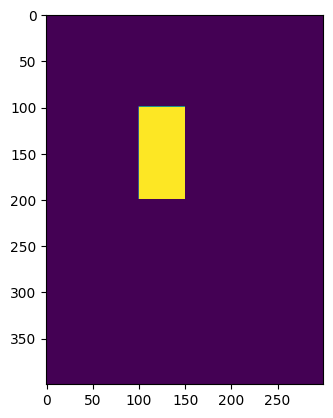

In [2]:
# simple test image - make it non-square so as to test the pixmap shaping algorithm
sizex = 400
sizey = 300
data = np.zeros((sizex, sizey), dtype='float32')
weights = np.ones((sizex, sizey), dtype='float32')

# image made of zeros, except for a rectangular area with ones
data[100:200, 100:150] = 1

# plt.imshow(data[90:110,90:110], vmin=0, vmax=1)
plt.imshow(data, vmin=0, vmax=1)

In [3]:
# pixmap is built following the "recipe" in the `drizzle.calc_pixmap` function
idxmap = np.indices((sizey, sizex), dtype='float64') # note the apparent swapping of X and Y axis...

idxmap = idxmap.transpose()
idxmap = idxmap.reshape(sizex * sizey, 2)

# here we add the offsets. In this example we are adding a single value offset that 
# generates a fractional pixel coverage at object edges. 

idxmap += 50.5

pixmap = idxmap.reshape(sizex, sizey, 2)

In [4]:
# allocate output arrays
output_data = np.zeros((sizex, sizey), dtype='float32')
output_counts = np.zeros((sizex,sizey), dtype='float32')
output_context = np.zeros((sizex, sizey), dtype='int32')

# call C core drizzle algorithm
cdrizzle.tdriz(data, weights, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 32500, 48)

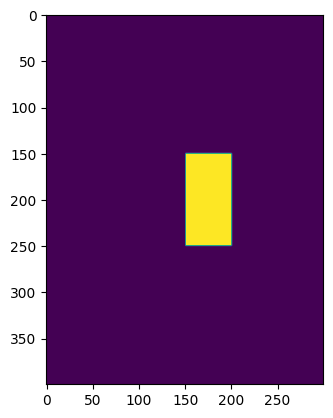

In [5]:
# plt.imshow(output_data[140:160,140:160], vmin=0, vmax=1)
plt.imshow(output_data, vmin=0, vmax=1)

The output array above shows fractional pixel coverage effects at the object edges, compatible with the offsets added to the pixmap.

## Apply drizzle to a small subset of a real image

In [6]:
# reference image used in the Offsets scripts. Offsets are defined against this image.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.ARW')
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

In [7]:
# last image in sequence. This should have the largest offsets.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03829.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

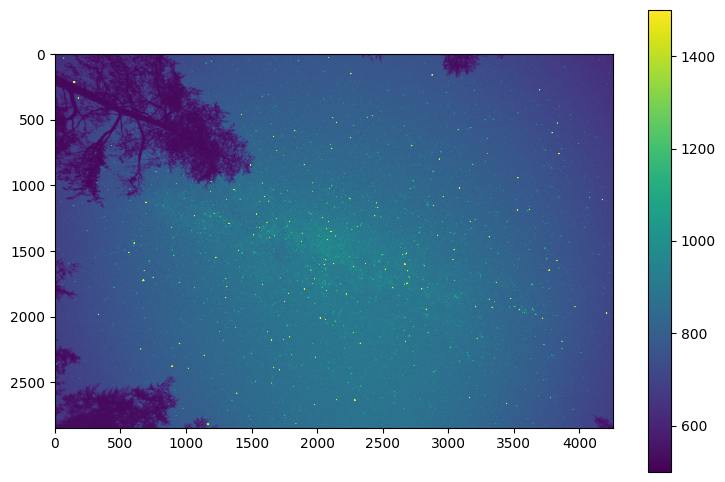

In [8]:
plt.figure(figsize=[9, 6])
plt.imshow(reference_imarray, vmin=500, vmax=1500)
plt.colorbar()

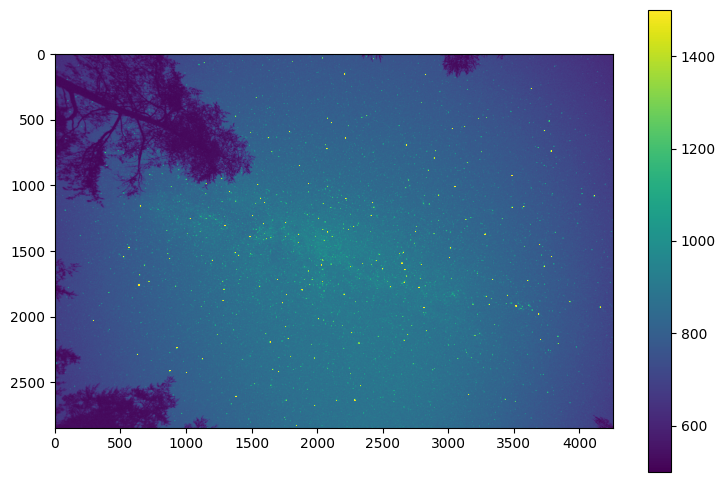

In [9]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray, vmin=500, vmax=1500)
plt.colorbar()

In [10]:
aslice = np.index_exp[1150:1240,1950:2050]
# aslice = np.index_exp[1000:1500,800:1300]

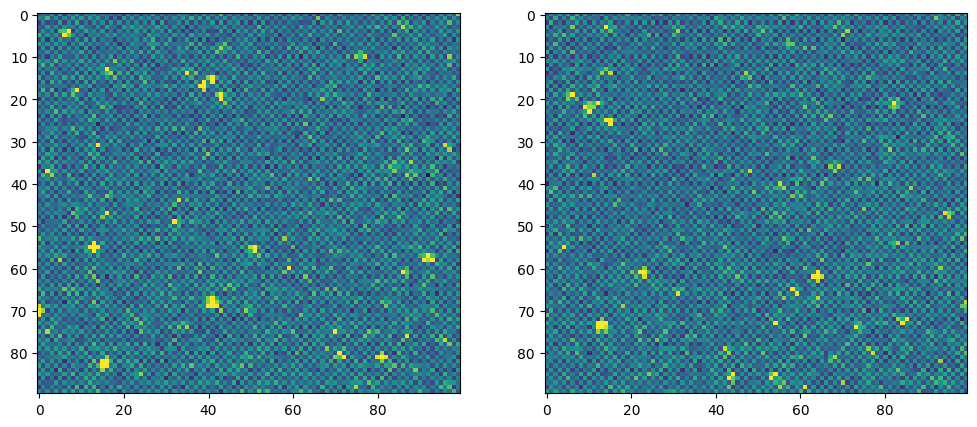

In [11]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(imarray[aslice], vmin=500, vmax=1500)

In [12]:
# pixmap comes from offsets file
fname_offsets = fname.replace('ARW', 'offsets.fits')

f = fits.open(fname_offsets)
pixmap_x = f[1].data
pixmap_y = f[2].data
f.close()

In [13]:
# pixmap
shape = (2, pixmap_x.shape[0], pixmap_x.shape[1])
i_pixmap = np.zeros(shape)

print(i_pixmap.shape)

i_pixmap[0] = pixmap_x
i_pixmap[1] = pixmap_y

t_pixmap = i_pixmap.transpose()

# weigths
weights = np.ones(imarray.shape, dtype='float32')

# output arrays
output_data = np.zeros(imarray.shape, dtype='float32')
output_counts = np.zeros(imarray.shape, dtype='float32')
output_context = np.zeros(imarray.shape, dtype='int32')

print(imarray.shape)
print(i_pixmap.shape)
print(t_pixmap.shape)
print(weights.shape)


(2, 2848, 4256)
(2848, 4256)
(2, 2848, 4256)
(4256, 2848, 2)
(2848, 4256)


In [14]:
# call C core drizzle algorithm
cdrizzle.tdriz(imarray, weights, t_pixmap, output_data, output_counts, output_context)

ValueError: Invalid input array

In [ ]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_data[aslice], vmin=500, vmax=1500)